In [1]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

from cyecca.util import sqrt_correct, sqrt_covariance_predict
from cyecca.lie.group_so3 import *
from cyecca.lie.group_rn import *

# Constants

In [2]:
# unit vectors
e1 = ca.SX([1, 0, 0])
e2 = ca.SX([0, 1, 0])
e3 = ca.SX([0, 0, 1])

# ---------------------------------------------------------------
# parameters
mag_decl = ca.SX.sym("mag_decl")  # magnetic declination radians
mag_incl = ca.SX.sym("mag_incl")  # magnetic inclination radians
mag_str = ca.SX.sym("mag_str")  # magnetic inclination radians
mag_std = ca.SX.sym("mag_std")  # magnetic inclination radians
dt = ca.SX.sym("dt")  # prediction period, sec

gyro_std = ca.SX.sym("gyro_std")  # gyro
gyro_bias_rw_asd = ca.SX.sym(
    "gyro_bias_rw_asd"
)  # amplitude spectral density for random walk noise (rad/s) / sqrt(Hz)

In [3]:
# cov = psd * 1/dt
# std = =sqrt(psd) / sqrt(dt)

# State

$ G = \text{SO3Mrp} \times R_3$

In [4]:
# define vehicle state group (attitude, gyro_bias)
G = SO3Mrp * R3
g = G.algebra
X0 = G.elem(ca.SX.sym("x0", G.n_param))

# frames
# n : north, east, down, in local earth frame (NED)
# b : forward, right, down in body frame (FRD)

# define vehicle state subgroups
r_nb, b = G.sub_elems(X0)  # attitude mrp, gyro bias
R_nb = r_nb.to_Matrix()  # attitude matrix

In [5]:
g.elem(ca.vertcat(b.param, ca.SX(3, 1)))

SO3LieAlgebra x RnLieAlgebra: SX([x0_3, x0_4, x0_5, 00, 00, 00])

# State Prediction

$X_1 = X_0 \oplus W dt$

In [6]:
omega = G.algebra.elem(ca.SX.sym("omega", 6))  # true angular velocity
omega_m = omega - g.elem(ca.vertcat(b.param, ca.SX(3, 1)))  # angular velocity with bias
omega_m

SO3LieAlgebra x RnLieAlgebra: SX([(omega_0-x0_3), (omega_1-x0_4), (omega_2-x0_5), omega_3, omega_4, omega_5])

In [7]:
type(omega)

cyecca.lie.direct_product.LieAlgebraDirectProductElement

In [8]:
# this is a geodetic (assuming constant gyro), so euler prediction is exact
# this is equivalent to:
# X = X*(W*dt).exp(lie.SO3Mrp)
X1 = X0 + omega_m * dt


def shadow_if_necessary(X1):
    r1, b1 = G.sub_elems(X1)
    SO3Mrp.shadow_if_necessary(r1)
    return G.elem(param=ca.vertcat(r1.param, b1.param))


f_predict = ca.Function(
    "predict",
    [omega.param, X0.param, dt],
    [shadow_if_necessary(X1).param],
    ["omega", "x0", "dt"],
    ["x1"],
)


def error_log():
    X0 = G.elem(ca.SX.sym("x0", 6))
    X1 = G.elem(ca.SX.sym("x1", 6))
    e_log = shadow_if_necessary(X0 * X1.inverse()).param
    f_log_error = ca.Function(
        "log_error", [X0.param, X1.param], [e_log], ["x0", "x1"], ["e_log"]
    )
    f_log_error(np.zeros(6), np.zeros(6))
    return f_log_error


f_log_error = error_log()

# test it works
print("predict", f_predict([0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], 1))

predict [0, 0, 0, 0, 0, 0]


# Covariance Propagation

$\dot{\zeta} = -\text{ad}_{\omega} \zeta$

$\eta = e^{\zeta}$

In [9]:
# zeta = ca.SX.sym("zeta", 6)
# zeta_dot = -omega_m.ad() @ zeta
# A = ca.jacobian(zeta_dot, zeta)
# A

In [10]:
# error dynamics
zeta = ca.SX.sym("zeta", G.algebra.n_param)
omega = G.algebra.elem(ca.SX.sym("omega", G.algebra.n_param))

# this works becomse ad for R3 is zero, won't work for SE23
# zeta_dot = -omega.ad() @ zeta
# A = ca.jacobian(zeta_dot, zeta)
# A

In [11]:
gyro_bias_rw_std = gyro_bias_rw_asd / ca.sqrt(dt)
Q = ca.diag(
    ca.vertcat(
        gyro_std,
        gyro_std,
        gyro_std,
        gyro_bias_rw_std,
        gyro_bias_rw_std,
        gyro_bias_rw_std,
    )
    ** 2
)
Q

SX(@1=(gyro_bias_rw_asd/sqrt(dt)), 
[[sq(gyro_std), 00, 00, 00, 00, 00], 
 [00, sq(gyro_std), 00, 00, 00, 00], 
 [00, 00, sq(gyro_std), 00, 00, 00], 
 [00, 00, 00, sq(@1), 00, 00], 
 [00, 00, 00, 00, sq(@1), 00], 
 [00, 00, 00, 00, 00, sq(@1)]])

In [12]:
ca.SX(3, 1)

SX([00, 00, 00])

In [13]:
def covariance_predict():
    W = ca.SX.sym("W", ca.Sparsity_lower(G.n_param))
    W_dot = ca.tril(sqrt_covariance_predict(W, A, Q))
    return ca.Function(
        [x, W, omega_m, std_gyro, gyro_bias_asd, dt],
        [W_dot],
        ["x", "W", "omega_m", "std_gyro", "gyrro_bias_asd", "dt"],
        ["W_dot"],
    )

# Magnetometer Correction

In [14]:
# calculate mag vector in body frame
R_nm = SO3EulerB321.elem(ca.vertcat(mag_decl, -mag_incl, 0)).to_Matrix()
B_n = R_nm @ e1
B_b = R_nb.T @ B_n
mag_w = ca.SX.sym("mag_w", 3)

f_y_mag = ca.Function(
    "y_mag",
    [X0.param, mag_str, mag_decl, mag_incl, mag_std, mag_w],
    [B_b + mag_w * mag_std],
    ["x", "mag_str", "mag_decl", "mag_incl", "std_mag", "mag_w"],
    ["y"],
)

# projection of mag into plane, with unit norm
yh_mag = f_y_mag(X0.param, 1, mag_decl, 0, 0, 0)
gamma = ca.acos(yh_mag[2] / ca.norm_2(yh_mag))
h = ca.fmax(ca.sin(gamma), 1e-3)

y_mag_b = ca.SX.sym("y_mag", 3)
y_mag_n = R_nb @ y_mag_b

H_mag = ca.SX(1, 6)
H_mag[0, 2] = 1


# test it works
print("y_mag", f_y_mag([0, 0, 0, 0, 0, 0], [1], [0], [0], [1], [0, 0, 0]))

y_mag [1, 0, 0]


In [15]:
zeta = ca.SX.sym("zeta", G.n_param)
omega = G.algebra.elem(ca.SX.sym("omega", G.n_param))

# this works becomse ad for R3 is zero, won't work for SE23
# zeta_dot = -omega.ad() @ zeta
# F = ca.jacobian(zeta_dot, zeta)
# F

# Simulation

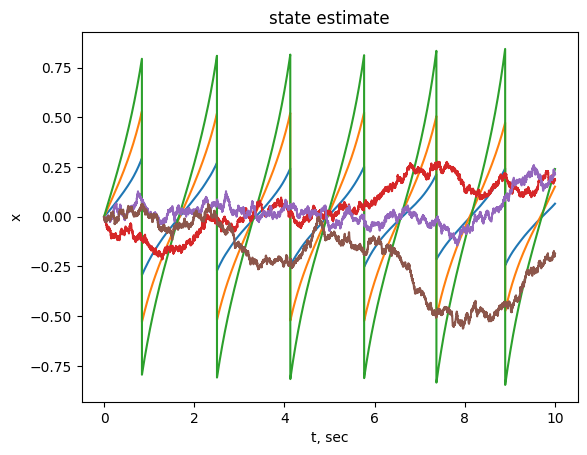

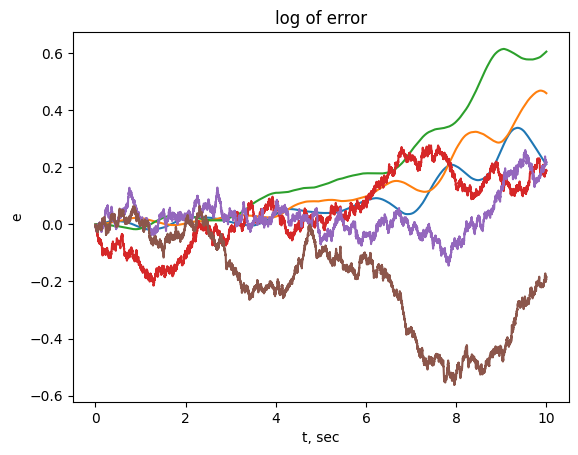

In [16]:
def simulate(t0=0, tf=10, dt=0.001):
    t = t0

    # initial estimator state
    x = np.array([0, 0, 0, 0, 0, 0])
    xh = np.array([0, 0, 0, 0, 0, 0])

    # history
    hist = {
        "x": [],
        "xh": [],
        "t": [],
        "e_log": [],
    }

    # simulation loop
    for t in np.arange(start=t0, stop=tf, step=dt):
        # true angular velocity of vehicle in body frame
        omega = np.array([1, 2, 3])

        # continuous process noise using constant power assumption
        gyro_bias_noise = (0.1 / ca.sqrt(dt)) * np.random.randn(3)

        # gyro sampling noise
        gyro_noise = 0.01 * np.random.randn(3)

        # extract state
        gyro_bias = x[3:]

        # true lie algebra
        w = np.hstack([omega, gyro_bias_noise])

        # true propagation
        x = np.array(f_predict(w, x, dt)).reshape(-1)

        # estimated lie algebra
        wh = np.hstack([omega + gyro_noise + gyro_bias, np.zeros(3)])

        # prediction
        xh = np.array(f_predict(wh, xh, dt)).reshape(-1)

        # compute log of error
        e_log = np.array(f_log_error(x, xh)).reshape(-1)

        # story history
        hist["x"].append(x)
        hist["xh"].append(xh)
        hist["e_log"].append(e_log)
        hist["t"].append(t)
        t += dt

    # turn history into arrays
    for k in hist.keys():
        hist[k] = np.array(hist[k])

    # plot
    plt.figure()
    plt.title("state estimate")
    plt.plot(hist["t"], hist["x"], label="true")
    # plt.plot(hist['t'], hist['xh'], label='est')
    plt.xlabel("t, sec")
    plt.ylabel("x")

    plt.figure()
    plt.title("log of error")
    plt.plot(hist["t"], hist["e_log"])
    plt.xlabel("t, sec")
    plt.ylabel("e")

    # plt.gca().set_xlim([3.12, 3.16])


simulate()